# Nonlinear PDE

Our goal is to solve the following nonlinear PDE:

$$ - \Delta u(x) + u(x)^3 = f(x), \quad x \in \Omega $$
$$ u(x) = g(x), \quad x\in\partial\Omega$$


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time

torch.set_default_dtype(torch.float64)

In [2]:
def sample_points(N_pts):
    """
    Generate interior and boundary points.
    """
    # interior points
    N_domain_tot = N_pts**2
    x_int_train = torch.rand(N_domain_tot, 1, requires_grad=True)
    y_int_train = torch.rand(N_domain_tot, 1, requires_grad=True)
    
    # boundary
    # bottom points
    x_bottom = torch.rand(N_pts+1, 1)
    y_bottom = torch.zeros(N_pts+1, 1)
    # top points
    x_top = torch.rand(N_pts+1, 1)
    y_top = torch.ones(N_pts+1,1)
    # concatenate
    x_bound_train = torch.concat((x_bottom, x_top))
    y_bound_train = torch.concat((y_bottom, y_top))
    # left points
    x_left = torch.zeros(N_pts+1,1)
    y_left = torch.rand(N_pts+1,1)
    # concat
    x_bound_train = torch.concat((x_bound_train, x_left))
    y_bound_train = torch.concat((y_bound_train, y_left))
    # right points
    x_right = torch.ones(N_pts+1,1)
    y_right = torch.rand(N_pts+1,1)
    # concat
    x_bound_train = torch.concat((x_bound_train, x_right))
    y_bound_train = torch.concat((y_bound_train, y_right))
    
    return x_int_train, y_int_train, x_bound_train, y_bound_train


def u_true(x, y):
    """
    Define true solution of the PDE.
    """
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y) + 2*torch.sin(4*torch.pi*x) * torch.sin(4*torch.pi*y)

def f(x, y):
    """
    Define RHS of the PDE.
    """
    u = u_true(x,y)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    return - u_xx - u_yy + u**3

def g(x,y):
    """
    Define the boundary condition of the PDE.
    """
    return u_true(x,y)

In [3]:
class RF_PDE(nn.Module):
    """
    Random feature model
    """
    
    def __init__(self, in_features, out_features, sigma=1.0):
        super(RF_PDE, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.sigma = sigma
        self.W = nn.Parameter(torch.randn(in_features, out_features) / sigma)
        self.b = nn.Parameter(torch.rand(out_features) * 2 * torch.pi)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))
    
    def forward(self,x,y):
        
        inputs = torch.cat((x,y), dim=1)
        u = self.model(torch.cos(inputs @ self.W + self.b) * torch.sqrt( torch.tensor([2 / self.out_features])))
        return u
    
    
class PINN(nn.Module):
    """
    Physics-informed neural network
    """    
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(2,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,1))
        
    def forward(self,x,y):
        
        inputs = torch.cat((x,y), dim=1)
        u = self.model(inputs)
        return u
    
    
def loss_fn(model, x_int, y_int, x_bound, y_bound, RHS, g):
    """
    Compute the loss
    """
    
    # interior:
    u = model(x_int,y_int)
    u_x = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_int, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_int, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    f = RHS(x_int,y_int)
    
    residual = - u_xx - u_yy + u**3 - f
    
    # boundary
    residual_bound = model(x_bound, y_bound) - g(x_bound, y_bound)

    return torch.mean(residual**2) + torch.tensor([1e6]) * torch.mean(residual_bound**2)

def train(model, optimizer, x_int, y_int, x_bound, y_bound, RHS, g, epochs=1000):
    """
    Train models
    """
    losses = []
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        loss = loss_fn(model, x_int, y_int, x_bound, y_bound, RHS, g)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return losses

## Comparison on time and visualization

In this section, we compare the computational times of RF and PINN. Then, we visualize the result of RF.

In [4]:
# generate training points
N_pts = 30
x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)

################### Random Feature 
# initialize Random Feature model and optimizer
N = 1000
model_RF = RF_PDE(2, N, sigma = 0.1)
optimizer = optim.Adam(model_RF.parameters(), lr=1e-2)
# Train the model
start = time.time()
losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

Computational time is 99.05 seconds


In [5]:
# generate test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)

XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)

u_truth = u_true(XX,YY)
u_truth = u_truth.detach().numpy()

# prediction by Random Feature model
RF_pred = model_RF(XX_test, YY_test)
RF_pred = RF_pred.detach().numpy()
RF_pred = RF_pred.reshape(num_pts,num_pts)

err_RF = np.sum( (u_truth - RF_pred)**2 ) / np.size(u_truth)
print(err_RF)

0.00014396948965145494


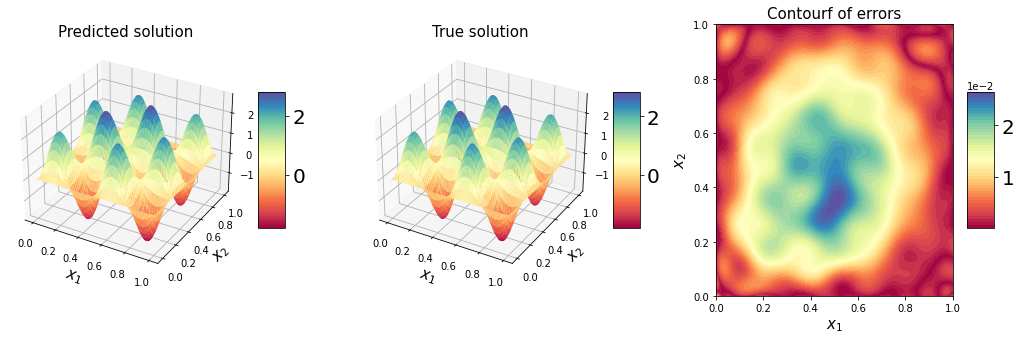

In [10]:
## visualization

fig = plt.figure(figsize=(18,5))
# plot the true solution
ax = fig.add_subplot(132, projection='3d')
u_truth_surf=ax.plot_surface(XX, YY, u_truth, cmap='Spectral')
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('True solution', size=15)
cbar = fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot the test solution
ax = fig.add_subplot(131, projection='3d')
u_test_surf=ax.plot_surface(XX, YY, RF_pred, cmap='Spectral')
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('Predicted solution', size=15)
cbar = fig.colorbar(u_test_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot error
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, abs(u_truth-RF_pred), 50, cmap='Spectral')
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('Contourf of errors',size=15)
cbar = fig.colorbar(u_contourf, shrink= 0.5, aspect = 5, ticks=[0.01,0.02])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
plt.savefig('Nonlinear_PDE.pdf', bbox_inches = 'tight')

In [7]:
################### PINN: 1000 epochs
# initialize model and optimizer
model_PINN = PINN()
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)

# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

## test and prediction
PINN_pred = model_PINN(XX_test, YY_test)
PINN_pred = PINN_pred.detach().numpy()
PINN_pred = PINN_pred.reshape(num_pts,num_pts)

err_PINN = np.sum( (u_truth - PINN_pred)**2 ) / np.size(u_truth)
print(err_PINN)

Computational time is 22.32 seconds
1.225847539153301


In [8]:
################### PINN: 20000 epochs
# initialize model and optimizer
model_PINN = PINN()
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)

# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=10000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

## test and prediction
PINN_pred = model_PINN(XX_test, YY_test)
PINN_pred = PINN_pred.detach().numpy()
PINN_pred = PINN_pred.reshape(num_pts,num_pts)

err_PINN = np.sum( (u_truth - PINN_pred)**2 ) / np.size(u_truth)
print(err_PINN)

Computational time is 169.28 seconds
0.013523347833109647


# Rate - number of collocation points

In [4]:
# number of collocation points
Points = [20,30,40]
T = 10
test_error = np.zeros((len(Points), T))

# test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)

XX, YY = np.meshgrid(xx, yy)
XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)

u_truth = u_true(XX,YY)
u_truth = u_truth.detach().numpy()

# number of random features
N = 100

# epochs
epochs = [800,800,2000]

for i in range(len(Points)):
    
    N_pts = Points[i]
    
    x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)
    
    for j in range(T):
        
        # initialize model and optimizer
        model_RF = RF_PDE(2, N, sigma = 0.1)
        optimizer = optim.Adam(model_RF.parameters(), lr=1e-2)

        # Train the model
        losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=epochs[i])
    
        # test error
        RF_pred = model_RF(XX_test, YY_test)
        RF_pred = RF_pred.detach().numpy()
        RF_pred = RF_pred.reshape(num_pts,num_pts)

    test_error[i,j] = np.sum( (u_truth - RF_pred)**2 ) / np.size(u_truth)

Epoch 0, Loss: 118292.84332011282
Epoch 0, Loss: 115149.75428269815
Epoch 0, Loss: 110402.43633738272
Epoch 0, Loss: 125137.06197275425
Epoch 0, Loss: 114393.80018775936
Epoch 0, Loss: 111611.22320485284
Epoch 0, Loss: 109545.8753852087
Epoch 0, Loss: 119528.23902011514
Epoch 0, Loss: 114959.1728953885
Epoch 0, Loss: 118752.32021891666
Epoch 0, Loss: 113454.76921555976
Epoch 0, Loss: 101364.5128779575
Epoch 0, Loss: 108961.2303334622
Epoch 0, Loss: 101996.882022481
Epoch 0, Loss: 103251.82578073216
Epoch 0, Loss: 102712.40312583337
Epoch 0, Loss: 100509.51944137864
Epoch 0, Loss: 108930.44748459659
Epoch 0, Loss: 106002.46207795283
Epoch 0, Loss: 101794.83799985413
Epoch 0, Loss: 102623.36614225831
Epoch 1000, Loss: 22.388639067248107
Epoch 0, Loss: 110585.14284844429
Epoch 1000, Loss: 22.63048061032515
Epoch 0, Loss: 111900.27209473355
Epoch 1000, Loss: 9.170147923651426
Epoch 0, Loss: 106834.42758497132
Epoch 1000, Loss: 13.37597818171241
Epoch 0, Loss: 120674.33072390172
Epoch 1000,

-3.414739810707539


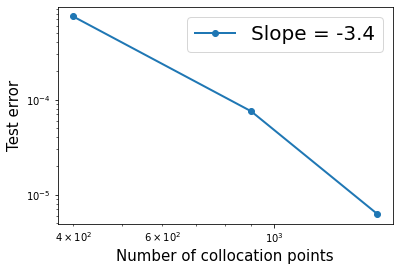

In [5]:
# compute slope
k = np.polyfit(np.log(Points), np.log(np.mean(test_error,axis=1)), deg=1)[0]/2
print(k)

# visualization
plt.loglog(np.power(Points,2), np.mean(test_error,axis=1), '-o', label=f'Slope = {k:.1f}', linewidth=2)
plt.legend(fontsize=20)
plt.xlabel('Number of collocation points', size=15)
plt.ylabel('Test error',size=15)
plt.savefig('Nonlinear_PDE_m.pdf', bbox_inches = 'tight')

# Rate - number of random features

In [6]:
N_pts = 20

N_range = [100,200,300]

T = 10
test_error = np.zeros((len(N_range),T))

# test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)

XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)

XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)

u_truth = u_true(XX,YY)
u_truth = u_truth.detach().numpy()
epochs = [900,900,1000]

for i in range(len(N_range)):
    
    N = N_range[i]
    x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)
    
    for j in range(T):
    
        # initialize model and optimizer
        model_RF = RF_PDE(2, N, sigma = 0.1)
        optimizer = optim.Adam(model_RF.parameters(), lr=1e-2)

        # Train the model
        losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=epochs[i])
    
        # test error
        RF_pred = model_RF(XX_test, YY_test)
        RF_pred = RF_pred.detach().numpy()
        RF_pred = RF_pred.reshape(num_pts,num_pts)

        test_error[i,j] = np.sum( (u_truth - RF_pred)**2 ) / np.size(u_truth)

Epoch 0, Loss: 112288.94401752482
Epoch 0, Loss: 111869.06332554383
Epoch 0, Loss: 113414.9677025944
Epoch 0, Loss: 108745.94154502309
Epoch 0, Loss: 110929.95168399507
Epoch 0, Loss: 116978.89798343215
Epoch 0, Loss: 118909.81497601866
Epoch 0, Loss: 109731.4961565108
Epoch 0, Loss: 107105.06943182813
Epoch 0, Loss: 118636.90099851375
Epoch 0, Loss: 108884.59014512846
Epoch 0, Loss: 110751.03634146182
Epoch 0, Loss: 109705.6374488201
Epoch 0, Loss: 108722.12564346798
Epoch 0, Loss: 115267.3149681262
Epoch 0, Loss: 109815.63360201147
Epoch 0, Loss: 109546.16502502552
Epoch 0, Loss: 109210.68807825573
Epoch 0, Loss: 109908.71520165705
Epoch 0, Loss: 108732.71573447163
Epoch 0, Loss: 103672.27008012665
Epoch 0, Loss: 103403.06329218188
Epoch 0, Loss: 103553.674001675
Epoch 0, Loss: 105442.54335116108
Epoch 0, Loss: 105078.9961177056
Epoch 0, Loss: 102545.60001584016
Epoch 0, Loss: 101564.01951698931
Epoch 0, Loss: 103469.04777302466
Epoch 0, Loss: 102182.12967295205
Epoch 0, Loss: 104329

-2.651766066052468


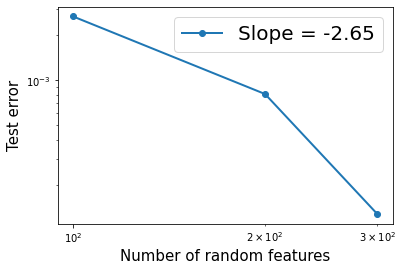

In [7]:
# compute slope
k = np.polyfit(np.log(N_range), np.log(np.mean(test_error,axis=1)), deg=1)[0]
print(k)

# visualization
plt.loglog(N_range, np.mean(test_error,axis=1), '-o', label=f'Slope = {k:.2f}', linewidth=2)
plt.legend(fontsize=20)
plt.xlabel('Number of random features', size=15)
plt.ylabel('Test error', size=15)
plt.savefig('Nonlinear_PDE_N.pdf', bbox_inches = 'tight')